# Data Visualization Notebook

## Objectives

*   To answer business requirement 1: 
    * The client is interested in conducting a study to visually differentiate 
      a cherry leaf that is healthy from one that contains powdery mildew. 
      Business requirement 1 shall consist of 3 sub-sections:
      1. To view the difference between average and variability image.
      2. To view differences between avarege healthy cherry leaves and average
        cherry leaves with powdery mildew.
      3. To view an image montage which when refreshed provides random images.


## Inputs

* inputs/cherry_leaves_dataset/cherry-leaves/train
* inputs/cherry_leaves_dataset/cherry-leaves/test
* inputs/cherry_leaves_dataset/cherry leaves/validation

## Outputs

* Image shape embeddings pickle file.
* Mean and variability of images per label plot.
* Plot to distinguish the contrast between powdery milddew 
  and healthy cherry leaf images
* Generate code that answers business requirement 1 and can be used 
  to build an image montage on the Streamlit dashboard.

---

## Set Data Directory

---

## Import libraries

First we need to import the required libraries

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

## Set working directory

In [12]:
cwd= os.getcwd()

In [13]:
os.chdir('/workspaces/milestone-project-mildew-detection-in-cherry-leaves')
print("You set a new current directory")

You set a new current directory


In [14]:
work_dir = os.getcwd()
work_dir

'/workspaces/milestone-project-mildew-detection-in-cherry-leaves'

## Set input directories

Create train, validation and test files.

In [15]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [16]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

#### Set label names

In [18]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['powdery_mildew', 'healthy']


---

# Data visualisation of image data

---

## Image shape

Compute average images size on train set.

We now need to find out the average image shape.

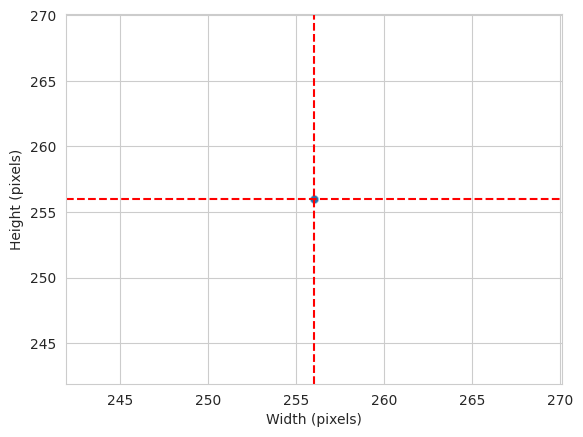

Width of average image: 256 
Height of average image: 256


In [22]:
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width of average image: {dim2_mean} \nHeight of average image: {dim1_mean}")

We can now see the width and height of the average image.

Images size for training the model is the average from all images in the train set.

In [25]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(256, 256, 3)

We now define the image shape by showing the average width of the image, average height of the image and 3 gradients (red, green and blue or standard RGB colour range)

Save the image shape embeddings

We shall now stabe the image shape into a pkl file for later use.

In [21]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

---

## Average and variability of images per label

This next section is for subsection 1 of Business requirment 1.

Now that we have our average image size, we can use it to create the average and variability of images per label.

#### Function to load images in an array (tensor)

We shall now load the imeages into an array using the image function from the tensor flow package.
This shall define the mean and standard deviation of pixel values in healthy cherry leaf images and cherry leaf images with a powdery mildew.
This function loads the images and their dimension using the image function. They are reshaped to the new dimesions of the number of images, height, widths and colour gradient.

In [26]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

2025-12-02 20:21:14.446078: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-02 20:21:29.125178: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Load image shapes and labels in an array

We shall now load iamges and labels of 30 images of average size and print out their shape.

In [27]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


#### Plot and save mean and variability of images per label

This next function loops over all lables, creates subsets of each label, calculates the mean and standard deviation, creates a figure displaying the mean and variability of images, then saves the image in the output folder.

In [55]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    """
    The pseudo-code for the function is:
    * Loop over all labels
    * Subset an array for a given label
    * Calculate the mean and standard deviation
    * Create a figure displaying the mean and variability of images
    * Save the image
    """

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for a {label_to_display} cherry leaf")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for a {label_to_display} cherry leaf")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

We are then able to plot the images and save them in the output directory.

==== Label healthy ====
Image Shape: (256, 256, 3)
==== Label powdery_mildew ====
Image Shape: (256, 256, 3)


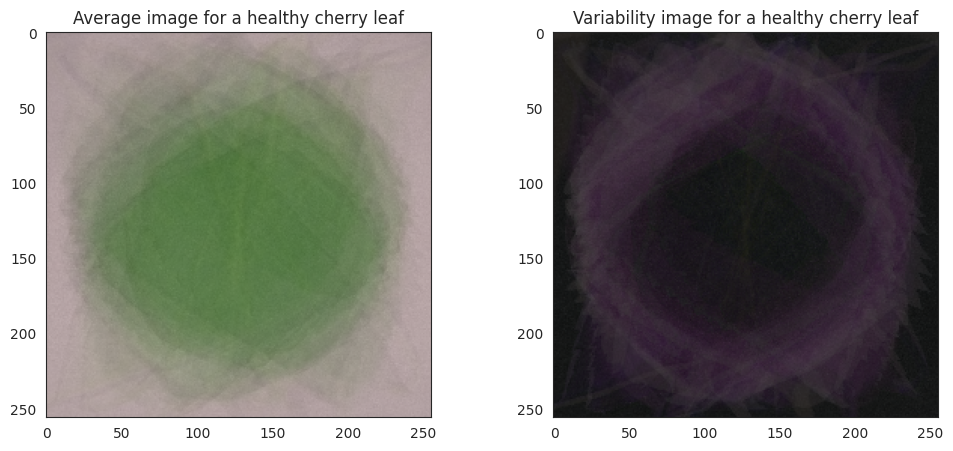

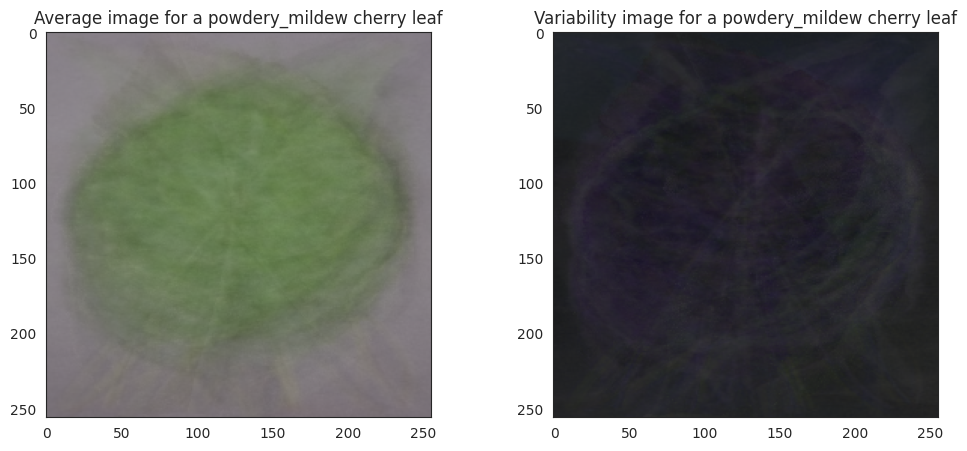

In [56]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)

---

## Difference between average powdery mildew and average healthy leaf images

---

This next section is for subsection 2 of Business Requirement 1.

It creates 3 images, an image of the average healthy cherry leaf, an image of the avarage cherry leaf with powdery mildew and thedifference between the average healthy cherry leaf and the avarage cherry leaf with powdery mildew.

In [94]:
def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, 
                                            figsize=(20, 5), save_image=False):
    """
    Checks if the labels exist in the set of unique labels
    Calculates the mean and difference for label1 and label2
    Plots a chart and saves it if save_image=True
    """
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(
            f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
        return

    # This section of code calculates the mean from the healthy label
    images_label = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label, axis=0)

    # This section of code calculates the mean from the powdery_mildew label
    images_label = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label, axis=0)

    # This section of code calculate difference and plot difference, average 
    # healthy label and average powdery_mildew label
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'An average {label_1}\n cherry leaf\n')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'An average {label_2}\n cherry leaf\n')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference between an average \n {label_1} cherry leaf and an \n average {label_2} cherry leaf\n')
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


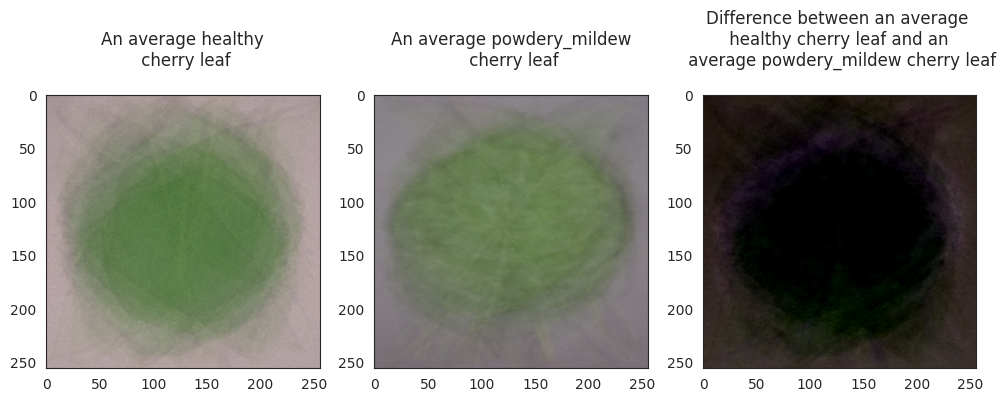

In [95]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='healthy', label_2='powdery_mildew',
                                        figsize=(12, 10),
                                        save_image=True
                                        )

---

## Image Montage

This next section is for subsection 3 of Business requirment 1.

In [25]:
# import itertools
# import random
# sns.set_style("white")


# def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
#     """
#     if the label exists in the directory
#     check if your montage space is greater than the subset size
#     create a list of axes indices based on nrows and ncols
#     create a Figure and display images
#     in this loop, load and plot the given image
#     """

#     labels = os.listdir(dir_path)

#     # subset the class you are interested to display
#     if label_to_display in labels:

#         # checks if your montage space is greater than the subset size
#         images_list = os.listdir(dir_path + '/' + label_to_display)
#         if nrows * ncols < len(images_list):
#             img_idx = random.sample(images_list, nrows * ncols)
#         else:
#             print(
#                 f"Decrease nrows or ncols to create your montage. \n"
#                 f"There are {len(images_list)} in your subset. "
#                 f"You requested a montage with {nrows * ncols} spaces")
#             return

#         # create a list of axes indices based on nrows and ncols
#         list_rows = range(0, nrows)
#         list_cols = range(0, ncols)
#         plot_idx = list(itertools.product(list_rows, list_cols))

#         # create a Figure and display images
#         fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
#         for x in range(0, nrows*ncols):
#             img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
#             img_shape = img.shape
#             axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
#             axes[plot_idx[x][0], plot_idx[x][1]].set_title(
#                 f"Width {img_shape[1]}px x Height {img_shape[0]}px")
#             axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
#             axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
#         plt.tight_layout()
#         plt.show()

#     else:
#         print("The label you selected doesn't exist.")
#         print(f"The existing options are: {labels}")

Run Montage in all labels

In [26]:
# for label in labels:
#     print(label)
#     image_montage(dir_path=train_path,
#                   label_to_display=label,
#                   nrows=3, ncols=3,
#                   figsize=(10, 15)
#                   )
#     print("\n")

---

END OF DATA VISUALISATION NOTEBOOK